In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [2]:
save_images = False
sep = ","
enc = "utf-8"
file = "correl_vs_gnn.csv"
df = pd.read_csv(file, sep=sep, header=0, encoding=enc)

In [3]:
def plot_alg_box(df, feat="OOA", suffixes=["GNN", "Correl"], ylabel=None,
        print_latex=False, ylim=None, figsize=(12,8), yticks=None):
    col_names = []
    title = feat
    for i in range(len(suffixes)):
        suffix = suffixes[i]
        col_name = feat + "_" + suffix
        col_names.append(col_name)
    sub_df = df.loc[:, col_names]
    
    if print_latex:
        df_desc = sub_df.describe(include="all")
        df_desc = df_desc.loc[["mean", "std", "25%", "50%", "75%"]]
        latex_str = df_desc.to_latex(escape=False, float_format="%.2f")
        latex_str = latex_str.replace("_", "\_")
        latex_str = latex_str.replace("%", "\%")
        latex_str = latex_str.replace("|S|", "$|\mathcal{S}|$")
        
        print(latex_str)
    
    sub_df.plot(kind="box", figsize=figsize, rot=90, title=title, grid=True,
        showmeans=True, ylabel=ylabel, ylim=ylim, yticks=yticks)

\begin{tabular}{lrr}
\toprule
{} &  OOA\_GNN &  OOA\_Correl \\
\midrule
mean &     0.77 &        0.74 \\
std  &     0.08 &        0.09 \\
25\%  &     0.72 &        0.68 \\
50\%  &     0.77 &        0.74 \\
75\%  &     0.82 &        0.80 \\
\bottomrule
\end{tabular}



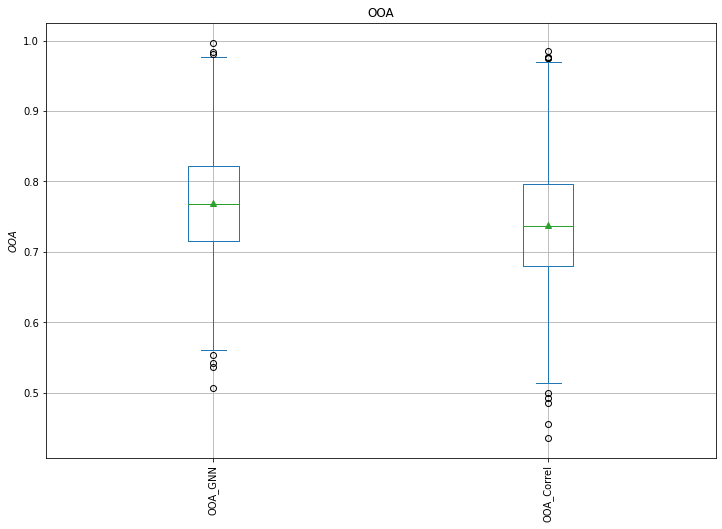

In [4]:
plot_alg_box(df=df, feat="OOA", ylabel=r"$OOA$", print_latex=True)
if save_images:
    plt.savefig("correl_vs_gnn_ooa.png", bbox_inches="tight")

\begin{tabular}{lrr}
\toprule
{} &  $|\mathcal{S}|$\_GNN &  $|\mathcal{S}|$\_Correl \\
\midrule
mean &   160.31 &      139.57 \\
std  &    97.27 &       86.35 \\
25\%  &    91.00 &       80.00 \\
50\%  &   141.00 &      123.00 \\
75\%  &   207.00 &      178.00 \\
\bottomrule
\end{tabular}



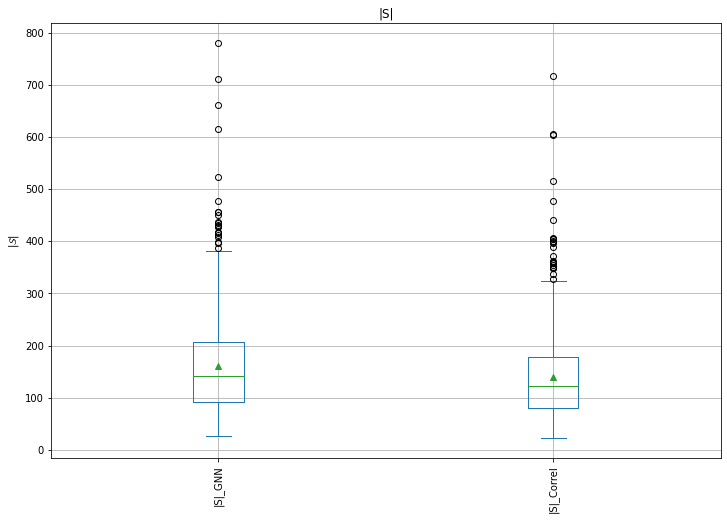

In [5]:
plot_alg_box(df=df, feat="|S|", ylabel=r"$|\mathcal{S}|$", print_latex=True)
if save_images:
    plt.savefig("correl_vs_gnn_sizes.png", bbox_inches="tight")

\begin{tabular}{lrr}
\toprule
{} &  BCE\_GNN &  BCE\_Correl \\
\midrule
mean &     1.03 &        5.33 \\
std  &     0.20 &        1.09 \\
25\%  &     0.92 &        4.66 \\
50\%  &     1.01 &        5.34 \\
75\%  &     1.13 &        6.01 \\
\bottomrule
\end{tabular}



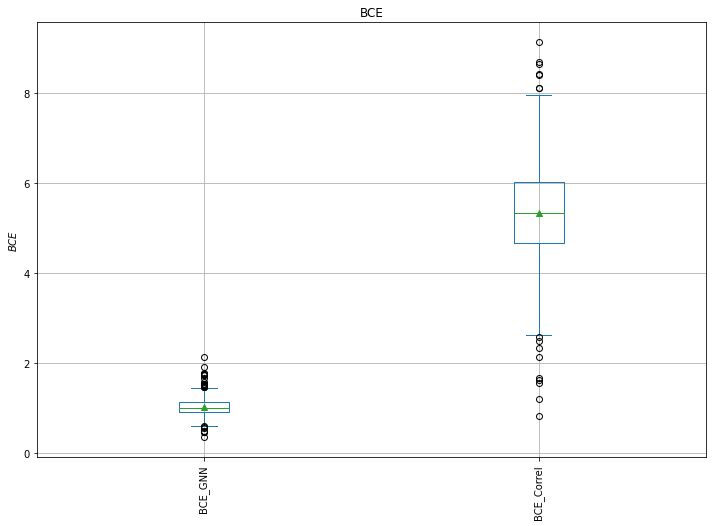

In [6]:
plot_alg_box(df=df, feat="BCE", ylabel=r"$BCE$", print_latex=True)
if save_images:
    plt.savefig("correl_vs_gnn_bce.png", bbox_inches="tight")

In [7]:
def outliers_idxs(arr):    
    q025 = np.quantile(a=arr, q=0.25, axis=0)
    q075 = np.quantile(a=arr, q=0.75, axis=0)
    iqr = q075 - q025
    lb = q025 - 1.5 * iqr
    ub = q075 + 1.5 * iqr
    mask = (arr >= ub) | (arr <= lb)
    out_rows = np.where(mask == True)[0]
    return out_rows


def ut_test(df, alpha=0.05, feat="OOA", suffixes=["GNN", "Correl"]):
    col_names = []
    title = feat
    print(title)
    if len(suffixes) != 2:
        raise Exception("Cannot apply u- or t-Test")
    for i in range(len(suffixes)):
        suffix = suffixes[i]
        col_name = feat + "_" + suffix
        col_names.append(col_name)
    sub_df = df.loc[:, col_names]
    
    idxs_0 = outliers_idxs(arr=sub_df[col_names[0]].to_numpy())
    idxs_1 = outliers_idxs(arr=sub_df[col_names[1]].to_numpy())
    out_idxs = np.vstack((idxs_0[:, None], idxs_1[:, None]))
    out_idxs = np.unique(out_idxs)
    print("Remove {0} outliers".format(out_idxs.shape[0]))
    remaining_idxs = np.arange(df.shape[0], dtype=np.uint32)
    remaining_idxs = np.delete(remaining_idxs, out_idxs)
    sub_df = sub_df.iloc[remaining_idxs, :]
    
    is_normal = True
    for i in range(len(col_names)):
        col_name = col_names[i]
        _, p_val = st.shapiro(sub_df[col_name])
        is_col_normal = p_val < alpha
        print("{0} is normal: {1} (p={2})".format(col_name, is_col_normal, p_val))
        is_normal = is_normal and is_col_normal
    _, p_val = st.bartlett(sub_df[col_names[0]], sub_df[col_names[1]])
    equal_var = p_val < alpha
    print("Equal variance: {0} (p={1})".format(equal_var, p_val))
    if is_normal and equal_var:
        _, p_val = st.ttest_ind(a=sub_df[col_names[0]], b=sub_df[col_names[1]])
        significant = p_val < alpha
        print("T-Test for {0} is significant: {1} (p={2:.5f})".format(title, significant, p_val))
    else:
        _, p_val = st.mannwhitneyu(x=sub_df[col_names[0]], y=sub_df[col_names[1]])
        significant = p_val < alpha
        print("U-Test for {0} is significant: {1} (p={2:.5f})".format(title, significant, p_val))

In [8]:
ut_test(df=df, feat="OOA")

OOA
Remove 13 outliers
OOA_GNN is normal: False (p=0.09741829335689545)
OOA_Correl is normal: False (p=0.0968070924282074)
Equal variance: True (p=0.00154025179858274)
U-Test for OOA is significant: True (p=0.00000)


In [9]:
ut_test(df=df, feat="|S|")

|S|
Remove 26 outliers
|S|_GNN is normal: True (p=1.615005465515143e-13)
|S|_Correl is normal: True (p=3.382008215147003e-13)
Equal variance: True (p=0.00047573427666440244)
T-Test for |S| is significant: True (p=0.00000)


In [10]:
ut_test(df=df, feat="BCE")

BCE
Remove 36 outliers
BCE_GNN is normal: False (p=0.06233848258852959)
BCE_Correl is normal: False (p=0.4101633131504059)
Equal variance: True (p=0.0)
U-Test for BCE is significant: True (p=0.00000)
